In [4]:
# General imports and widgets
import os
if os.getcwd().split('/')[-1] != 'deepARTransit':
    os.chdir('../..')
import sys
import warnings
import numpy as np
import matplotlib.pylab as plt
from pixlc import plotting
import ipywidgets as widgets

plt.rcParams['figure.figsize'] = (16, 6)
plt.rcParams['font.size'] = 15
warnings.simplefilter("ignore")

# Project dir selection widget

project_button = widgets.Dropdown(
    options=[os.path.join('.'), # local git repo
             os.path.join('/','Users','Mario','mount_test','deepARTransit') # cobweb         
],
    #value=experiment_folder,
    # rows=10,
    description='\t\t',
    disabled=False
)

# Experiment selection widget

experiment_button = widgets.Dropdown(
    options=[os.path.join('deeparsys_fulltime'),
             os.path.join('cobweb', 'deeparsys_dev'),
             os.path.join('cobweb', 'deeparsys_fulltime'),
             os.path.join('cobweb', 'deepartrans_fulltime'), 
             os.path.join('cobweb', 'rlc', 'deeparsys_nocov'),
             os.path.join('cobweb', 'rlc', 'deeparsys_cent'),
             os.path.join('cobweb', 'rlc', 'deeparsys_cent_2'),
             os.path.join('cobweb', 'rlc','deeparsys_pix'),
             os.path.join('cobweb', 'rlc','deeparsys_cent_pix'),
             os.path.join('cobweb', 'rlc','deeparsys_cent_24537600'),
             os.path.join('cobweb', 'rlc','deeparsys_cent_22808832'),
             os.path.join('cobweb', 'rlc','deeparsys_cent_27773440'),
],
    #value=experiment_folder,
    # rows=10,
    description='\t\t',
    disabled=False
)

## Select a project directory for loading the data

In [335]:
project_button

Dropdown(description='\t\t', index=1, options=('.', '/Users/Mario/mount_test/deepARTransit'), value='/Users/Ma…

## Select an experiment

In [336]:
experiment_button

Dropdown(description='\t\t', index=1, options=('deeparsys_fulltime', 'cobweb/deeparsys_dev', 'cobweb/deeparsys…

In [396]:

# Loading the data
from utils.config import get_config_file, process_config
from deepartransit.data_handling import data_generator

experiment_folder = experiment_button.value
project_dir = project_button.value
experiment_dir = os.path.join(project_dir, 'deepartransit', 'experiments', experiment_folder)
print(experiment_dir)
config_file = get_config_file(experiment_dir)
config = process_config(config_file)
print('Data and covariates shapes:')
data = data_generator.DataGenerator(config)
width = int(np.sqrt(data.Z.shape[-1]))

traces_array = np.load(os.path.join(project_dir, config.output_dir, 'pred_array.npy')) #pred_array.npy
pred_instr = traces_array.mean(axis=(0))
length_pred = pred_instr.shape[1]
plc_trans = data.Z[:, config.pretrans_length:config.pretrans_length+config.trans_length+1]

/Users/Mario/mount_test/deepARTransit/deepartransit/experiments/cobweb/deeparsys_dev
Data and covariates shapes:
loading data from deepartransit/data/agol_transits_r2_nobacksub/rlc_artif_all.npy
(6, 330, 1) (6, 330, 2)
time_path parameter not found in config. Default to 0,1,2....T-1


In [397]:
# select an observation if several
obs = 0


## NN prediction = interpolation traces 

In [398]:
traces_array.shape, plc_trans.shape, pred_instr.shape, data.X.shape, data.Z.shape

((30, 6, 101, 1), (6, 101, 1), (6, 101, 1), (6, 330, 2), (6, 330, 1))

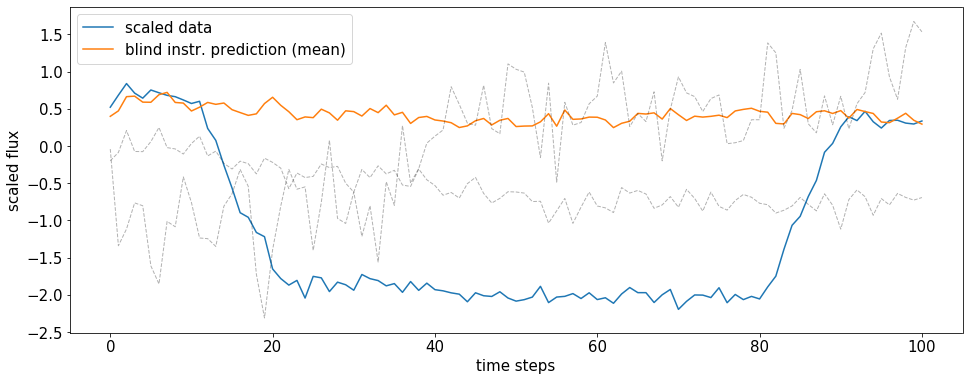

In [399]:
grid = plotting.plot_mozaic(plc_trans[obs].reshape(-1, width, width), label='scaled data')
#for trace in range(len(traces_array)):
#    plotting.plot_mozaic(np.expand_dims(traces_array[trace].T.reshape(-1, width, width), -1), 
#                         grid=grid, color='grey', linestyle='dashed', linewidth=1, alpha=0.3)
plotting.plot_mozaic(pred_instr[obs].reshape(-1, width, width), grid=grid, label='blind instr. prediction (mean)')
plt.plot(data.X[obs, config.pretrans_length:config.pretrans_length+config.trans_length+1],
        color='black', linestyle='dashed', linewidth=1, alpha=0.3)
plt.xlabel('time steps')
plt.ylabel('scaled flux')
plt.legend()

## Errors from traces

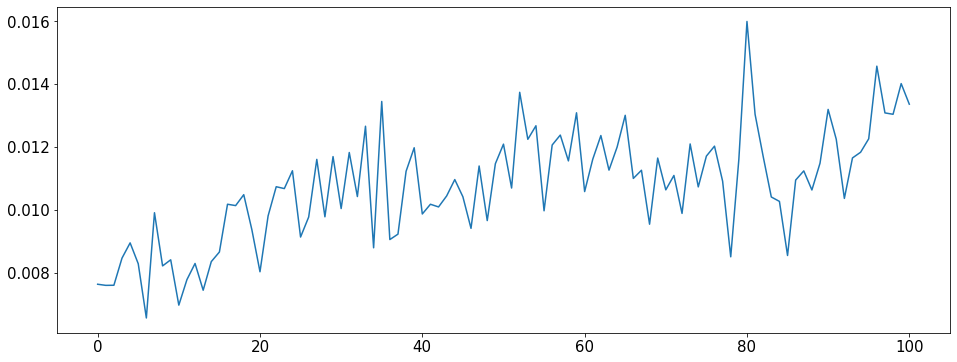

In [400]:
plt.plot(traces_array[:,obs].std(axis=0).flatten())

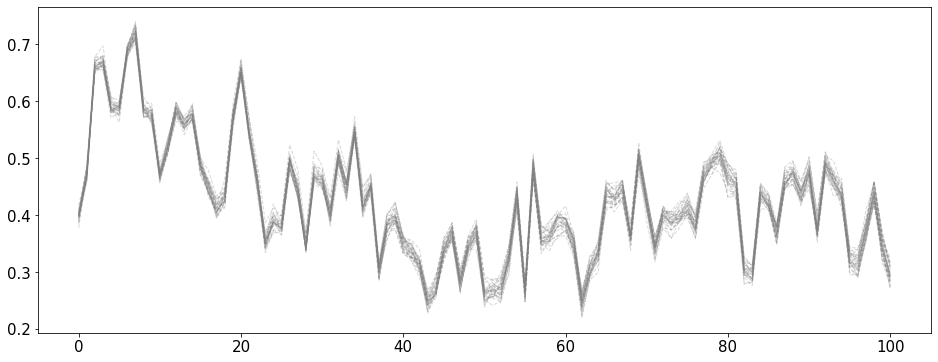

In [401]:
for trace in range(len(traces_array)):
    plotting.plot_mozaic(np.expand_dims(traces_array[trace,obs].T.reshape(-1, width, width), -1), 
                         grid=grid, color='grey', linestyle='dashed', linewidth=1, alpha=0.3)

## Back to Original units

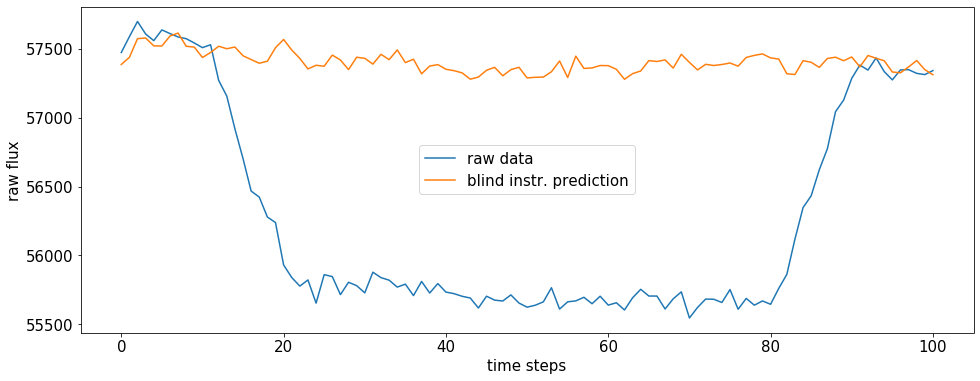

In [402]:
# Back to original scales
plc_trans = data.scaler_Z.inverse_transform(plc_trans)
pred_instr = data.scaler_Z.inverse_transform(pred_instr)
grid = plotting.plot_mozaic(plc_trans[obs].T.reshape(-1, width, width), grid=grid, label='raw data')
plotting.plot_mozaic(pred_instr[obs].T.reshape(-1, width, width), grid=grid, label='blind instr. prediction')
plt.xlabel('time steps')
plt.ylabel('raw flux')
plt.legend()

## Extracting the transit Component

(6, 101, 1)


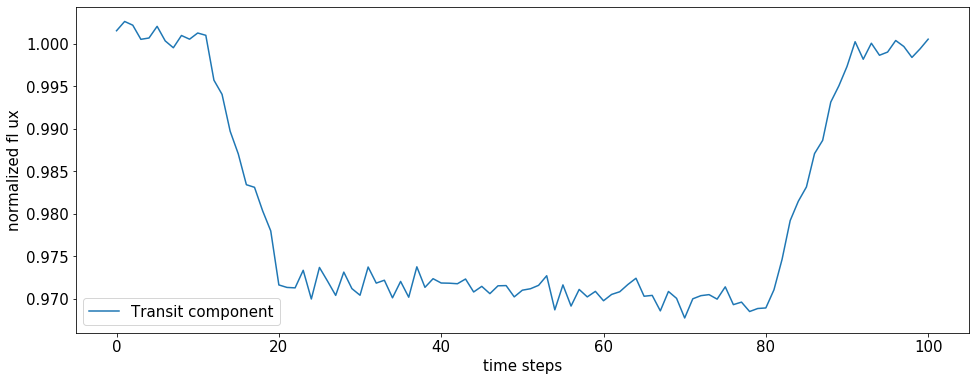

In [403]:
transit_component = (plc_trans/pred_instr)
print(transit_component.shape)
plotting.plot_mozaic(transit_component[obs].T.reshape(-1, width, width), label='Transit component')
plt.xlabel('time steps')
plt.ylabel('normalized fl ux')
plt.legend()

## Fitting a linear Transit to the transit component

In [404]:
from utils.transit import LinearTransit
time_array = np.arange(config.pretrans_length, config.pretrans_length + config.trans_length+1)
transit = LinearTransit(time_array)
transit.fit(np.expand_dims(transit_component[obs,:],0))
#(t_c, delta, T, tau) = fit_transit_linear(transit_component, repeat = width**2, time_array=time_array)
(t_c, delta, T, tau) = transit.transit_pars
print('mid_time = {:0.5f}'.format(t_c))
print('delta = {:0.6f} (Rp/Rs = {:0.5f})'.format(delta, np.sqrt(delta)))
print('T = {:0.5f}'.format(T))
print('tau = {:0.5f}'.format(tau))
print(np.sqrt(np.diag(transit.pcov)))

mid_time = 250.72888
delta = 0.029063 (Rp/Rs = 0.17048)
T = 59.77821
tau = 10.04676
[7.75436245e+01 1.29099445e-01 3.27933691e+02 2.74036072e+02]


In [405]:
# More transit params
t1 = t_c - T/2 - tau  # Beginning of ingress
t2 = t_c - T/2   # End of ingress
t3 = t_c + T/2  # Beginning of egress
t4 = t_c + T/2 + tau  # End of egress

MSE 4.176895833158685e-06


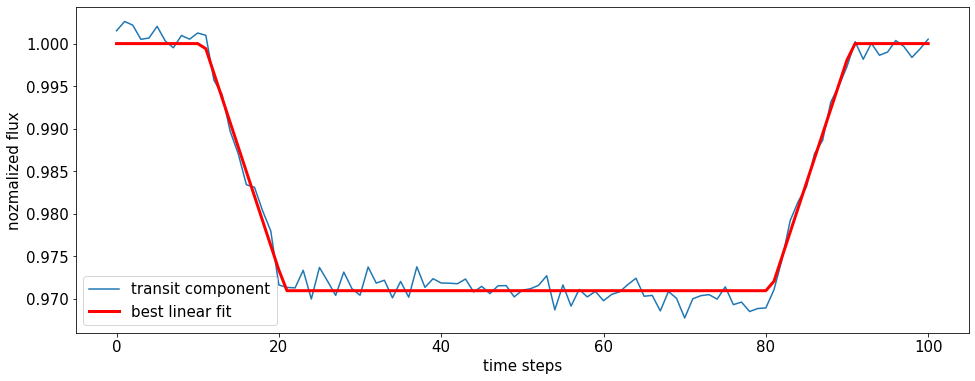

In [406]:
grid = plotting.plot_mozaic(transit_component[0].T.reshape(-1, width, width), label='transit component')
transit_fit_moz = np.expand_dims(transit.flux, -1).repeat(width**2, -1)
plotting.plot_mozaic(transit_fit_moz.reshape(-1,width, width), 
                     grid=grid, label='best linear fit', color='red', linewidth=3)
print('MSE',((transit_component.T - transit_fit_moz)**2).mean())
plt.xlabel('time steps')
plt.ylabel('nozmalized flux')
plt.legend()

## Back to the instrument prediction, compared to data/transit

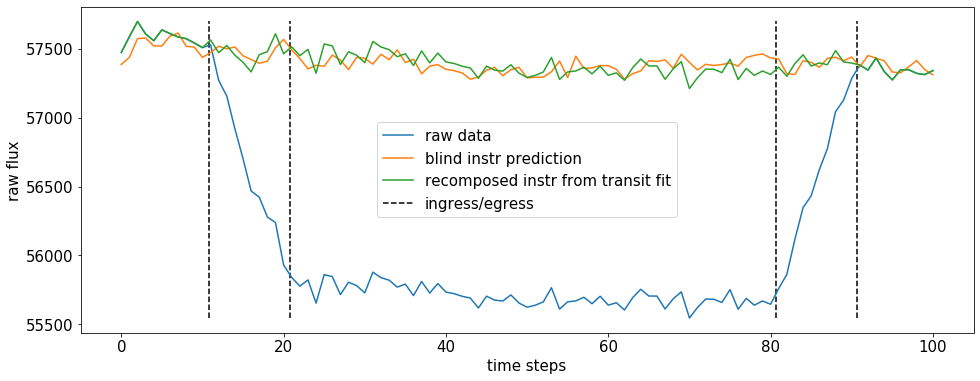

In [407]:
plt.plot(plc_trans[obs], label='raw data')
plt.plot(pred_instr[obs], label='blind instr prediction')
plt.plot(plc_trans[obs].sum(-1)/transit.flux, label='recomposed instr from transit fit')
plt.vlines(t1 - config.pretrans_length, plc_trans[obs].min(), plc_trans[obs].max(), linestyle='dashed', label = 'ingress/egress')
plt.vlines(t2 - config.pretrans_length, plc_trans[obs].min(), plc_trans[obs].max(), linestyle='dashed')
plt.vlines(t3 - config.pretrans_length, plc_trans[obs].min(), plc_trans[obs].max(), linestyle='dashed')
plt.vlines(t4 - config.pretrans_length, plc_trans[obs].min(), plc_trans[obs].max(), linestyle='dashed')
plt.xlabel('time steps')
plt.ylabel('raw flux')
plt.legend()

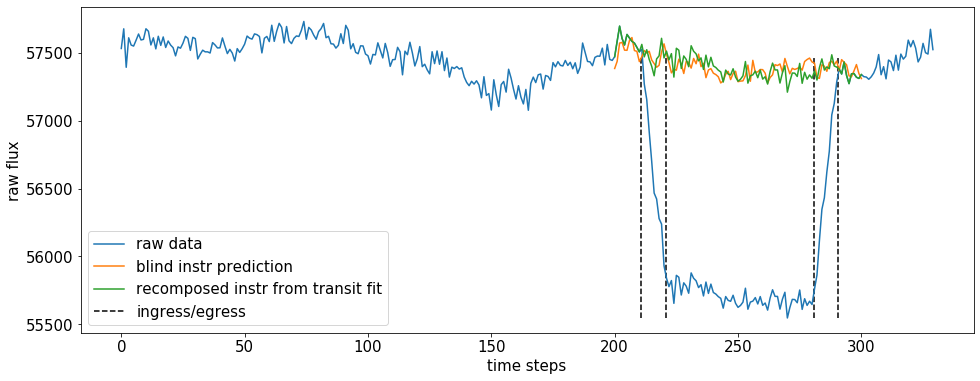

In [408]:
plt.plot(data.scaler_Z.inverse_transform(data.Z)[obs], label='raw data')

plt.plot(range(config.pretrans_length, config.pretrans_length+ config.trans_length + 1), 
         pred_instr[obs], label='blind instr prediction')
plt.plot(range(config.pretrans_length, config.pretrans_length+ config.trans_length + 1), 
         plc_trans[obs].sum((-1))/transit.flux, label='recomposed instr from transit fit')
plt.vlines(t1, plc_trans[obs].min(), plc_trans[obs], linestyle='dashed', label = 'ingress/egress')
plt.vlines(t2, plc_trans[obs].min(), plc_trans[obs], linestyle='dashed')
plt.vlines(t3, plc_trans[obs].min(), plc_trans[obs], linestyle='dashed')
plt.vlines(t4, plc_trans[obs].min(), plc_trans[obs], linestyle='dashed')
plt.xlabel('time steps')
plt.ylabel('raw flux')
plt.legend()
plt.show()
# covariates
# plt.plot(data.scaler_X.inverse_transform(data.X)[0,:,:], label='raw data')


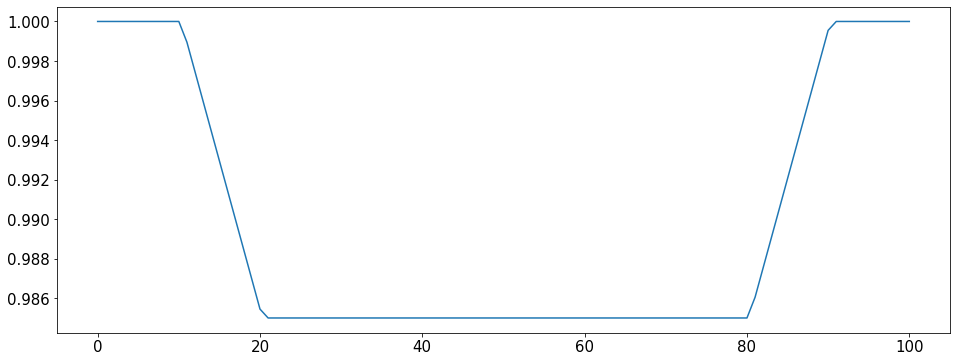

In [409]:
plt.plot((  LinearTransit(time_array, [250.3, 0.015, 60, 10]).flux))

In [410]:
data.scaler_Z.inverse_transform(data.Z)[obs].shape, LinearTransit(np.arange(330), [250.3, 0.015, 60, 10]).flux.shape

((330, 1), (330,))

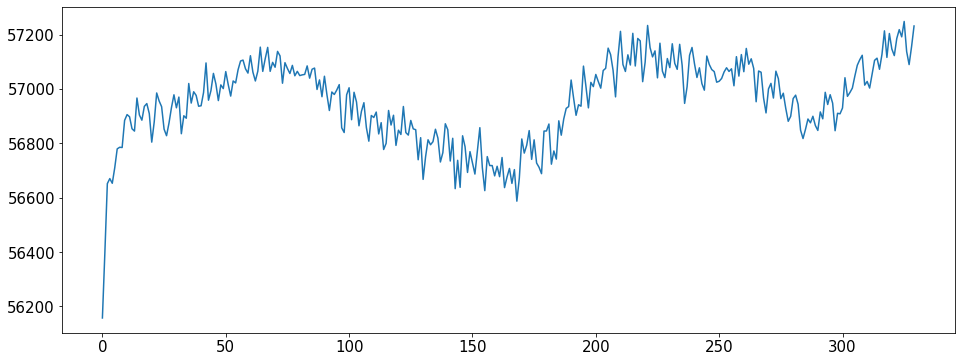

In [411]:
x = data.scaler_Z.inverse_transform(data.Z)[2,:,0] / LinearTransit(np.arange(330), [250.3, 0.03, 60, 10]).flux
plt.plot(x)